In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
# Desired image size
# imsize = 512 if torch.cuda.is_available() else 128
imsize = (512, 512)

loader = transforms.Compose([
    transforms.Resize(imsize),  # Scale imported image
    transforms.ToTensor()])     # Transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    image = image.convert('RGB')
    # Fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

unloader = transforms.ToPILImage()  # Reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()    # Clone the tensor to not do changes on it
    image = image.squeeze(0)        # Remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

In [40]:
content_path = 'content_images/'
style_path = 'style_images/'
output_path = 'output_images/'

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


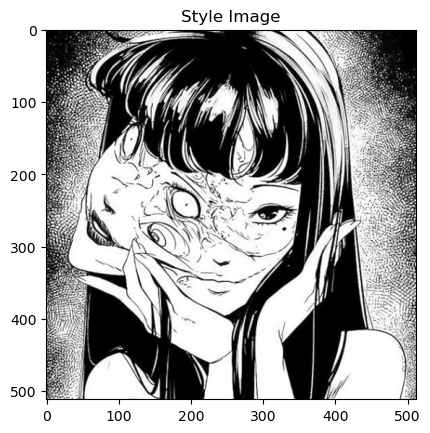

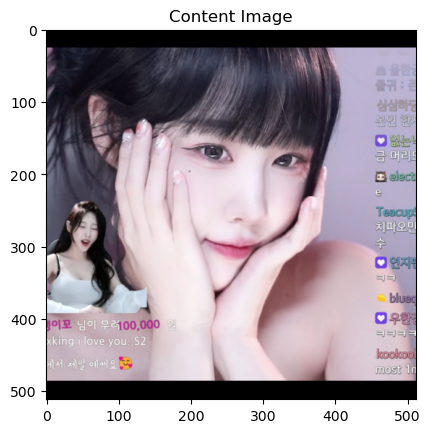

In [41]:
content_img_name = "han_kyung.jpg"
style_img_name = "junji_ito.jpg"

style_img = image_loader(style_path + style_img_name)
content_img = image_loader(content_path + content_img_name)

print(style_img.size(), content_img.size())
assert style_img.size() == content_img.size(), \
    "Style and content images must be the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [42]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# cnn = models.resnet50(weights='DEFAULT').to(device).eval()

In [43]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [44]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # Detach target content from the graph
        self.target = target.detach() * weight
        self.weight = weight
        self.loss = 0

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input * self.weight, self.target)
        return input

In [45]:
def gram_matrix(input):
    batch_size, feature_maps, h, w = input.size()
    features = input.view(batch_size * feature_maps, h * w)
    G = torch.mm(features, features.t())
    # Normalize the Gram Matrix
    return G.div(batch_size * feature_maps * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature, weight):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() * weight
        self.weight = weight
        self.loss = 0
    
    def forward(self, input):
        G = gram_matrix(input) * self.weight
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [46]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # Reshape mean and std to [C x 1 x 1] for broadcasting
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        # Normalize the image
        return (img - self.mean) / self.std

In [47]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [48]:
import copy  # Make sure to import the copy module

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # Normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Lists to hold content and style loss modules
    content_losses = []
    style_losses = []

    # Sequential model
    model = nn.Sequential(normalization)

    i = 0  # Increment every time a convolutional layer is added
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # In-place ReLU can cause problems, so use out-of-place version
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # Add style loss
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, weight=1)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

        # Add content loss
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, weight=1)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

    # Trim the model after the last content and style losses
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break

    model = model[:j+1]

    return model, style_losses, content_losses


In [49]:
white_noise = False
if white_noise:
    input_img = torch.randn(content_img.data.size(), device=device)
else:
    input_img = content_img.clone()
input_img.requires_grad_(True)
model, style_losses, content_losses = get_style_model_and_losses(cnn,
    cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

C:\Users\tu7ph\AppData\Local\Temp\ipykernel_15564\3380677498.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
C:\Users\tu7ph\AppData\Local\Temp\ipykernel_15564\3380677498.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1).to(device)


In [50]:
model 

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleLoss()
  (content_loss_4): ContentLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

In [51]:
# optimizer = optim.Adam([input_img], lr=0.01)
optimizer = optim.LBFGS([input_img])

In [52]:
def run_style_transfer(model, content_losses, style_losses, input_img, num_steps=200,
                       style_weight=10000, content_weight=1):
    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # Correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            # Accumulate style and content losses
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # Total loss
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("Step {}: Style Loss: {:4f} Content Loss: {:4f}".format(
                    run[0], style_score.item(), content_score.item()))
            return loss

        optimizer.step(closure)

    # Clamp the final output image
    input_img.data.clamp_(0, 1)
    return input_img

Optimizing...
Step 50: Style Loss: 0.000936 Content Loss: 40.392502
Step 100: Style Loss: 0.000408 Content Loss: 33.464939
Step 150: Style Loss: 0.000329 Content Loss: 31.864180
Step 200: Style Loss: 0.001056 Content Loss: 32.984833


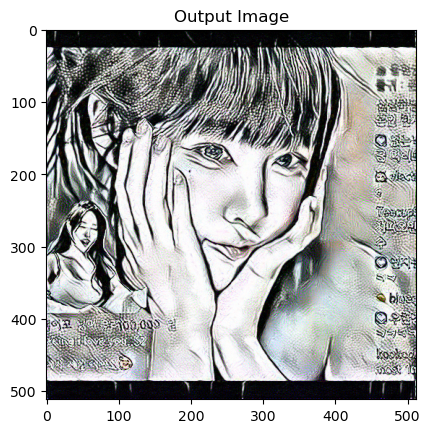

In [53]:
output = run_style_transfer(model, content_losses, style_losses, input_img)
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

In [54]:
output_image = output.cpu().clone()  # Clone the tensor to not do changes on it
output_image = output_image.squeeze(0)  # Remove the fake batch dimension
output_image = unloader(output_image)  # Reconvert into PIL image
if white_noise:
    output_image.save(output_path + content_img_name.split('.')[0] + "_white_noise_plus_" + style_img_name.split('.')[0] + '.jpg')
else:
    output_image.save(output_path + content_img_name.split('.')[0] + "_plus_" + style_img_name.split('.')[0] + '.jpg')